# About this notebook

Given that we obtained high recall score using Gradient Boosting Machines, we would like to further explore more specific real life scenarios. In real life, one of the reason flight delays is that the previous flight operated by the same aircraft was delayed, resulting in the subsequent flights not being operated as scheduled. Furthermore, as we found out from PageRank algorithm in the EDA section, airport hubs have high volumns of flights departing and arriving. Derived from this finding, we are interested in finding out whether there are flight patterns being affected by airport hubs. Here we utilize the motif finding function in GraphFrame library to find the potential consecutice flights operated by the same aircraft. With additional features of the source airport, such as weather data at two time points and airport evaluation scores, we built GBM model to see if we could improve predictions.

# Libraries, Global Variables, Classes, and Local Functions

In [0]:
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import ast
import os, sys
import airporttime
from datetime import datetime, timedelta, timezone
from collections import Counter
from pyspark.accumulators import AccumulatorParam
from pyspark.ml.functions import vector_to_array
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, array
from pyspark.sql.functions import split, col
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, max

# ML models
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from sparkdl.xgboost import XgboostClassifier
from pyspark.mllib.tree import GradientBoostedTrees
from pyspark.mllib.util import MLUtils
from graphframes import *
# Dimension reduction
from pyspark.ml.feature import PCA

# Evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics

# Visualization
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorSlicer, Imputer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import GBTClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_columns = None
from pyspark import SparkContext
from pyspark import SQLContext

from pyspark.sql.functions import *
from pyspark.ml import Pipeline

from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit


#Convert Integer Type to Double Type 
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from collections import defaultdict

In [0]:
# configuration 
blob_container = "team18" # The name of your container created in https://portal.azure.com
storage_account = "team18" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261team18" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "w261team18key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"
blob_url


# SAS Token
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

Out[4]: 'wasbs://team18@team18.blob.core.windows.net'

#### Custom CrossValidator

In [0]:
# Used pool.imap_unordered for parallelism but it could not reduce processing time
class CustomCrossValidator:  
    """
    Class to provide PageRank scores
    Args: 
        estimator         - (model) a model to be cross-validated
        split_word        - (string list) colum names for X and y
        step_length       - (integer) # days between two consecutive trainsets
        window_length     - (integer) # length of a trainset
        fh[fh1, fh2]      - (integer list) fh1 is # days between a trainset and a testset. fh2 is the length of testset  
        verbose           - (boolean) verbose 
    Desc:
                         Trainset                                 Testset
      fold #1  X--------------------------------X         O---------------------O
               |<-------- window_length-------->|<--fh1-->|<--------fh2--------->|
    
               |<--step_length-->|
                                             Trainset                             Testset
                    fold #2      X--------------------------------X         O---------------------O
                                 |<-------- window_length-------->|<--fh1-->|<--------fh2--------->|  
    """       
    
    def __init_output(self):
        """
        Initialize the output datastructures
        """
        self.number_fold_ = 0
        self.accuracy_ = []
        self.precision_ = []
        self.recall_ = []
        self.f1score_ = []    
  
    def __init__(self, estimator, split_word, step_length=30, window_length=30, fh=[1, 30], verbose=True):
        self.estimator = estimator
        self.target_var = split_word[1]
        self.step_length = step_length
        self.window_length = window_length
        self.fh = fh
        self.verbose = verbose

        self.__init_output()

    def __get_next_cv_time(self, init_time, window_length, fh):
        """
        Get the start and end dates of trainset and testset
        Args: 
            init_time         - (interger) Start date of the trainset
            window_length     - (integer) # length of a trainset
            fh[fh1, fh2]      - (integer list) fh1 is # days between a trainset and a testset. fh2 is the length of testset  
        Returns: 
            trainset_dt_s     - (Date) Start date of the trainset
            trainset_dt_e     - (Date) End date of the trainset
            testset_dt_s      - (Date) Start date of the testset
            testset_dt_e      - (Date) End date of the testset
            trainset_ts_s     - (integer) Start timestamp of the trainset
            trainset_ts_e     - (integer) End timestamp of the trainset
            testset_ts_s      - (integer) Start timestamp of the testset
            testset_ts_e      - (integer) End timestamp of the testset
        """
        trainset_dt_s = init_time
        trainset_dt_e = trainset_dt_s + timedelta(days = window_length)
        testset_dt_s = trainset_dt_e + timedelta(days = fh[0])
        testset_dt_e = testset_dt_s + timedelta(days = fh[1])

        trainset_ts_s = int((trainset_dt_s - datetime(1970, 1, 1)).total_seconds())
        trainset_ts_e = int((trainset_dt_e - datetime(1970, 1, 1)).total_seconds())
        testset_ts_s = int((testset_dt_s - datetime(1970, 1, 1)).total_seconds())
        testset_ts_e = int((testset_dt_e - datetime(1970, 1, 1)).total_seconds())  

        return trainset_dt_s, trainset_dt_e, testset_dt_s, testset_dt_e, trainset_ts_s, trainset_ts_e, testset_ts_s, testset_ts_e          

    def __run_model(self, model, trainset, testset, target_var, param):
        """
        Run the model in a fold and provide its preformance metrics
        Args: 
            model             - (model) model to be cross-validated
            trainset          - (DF) trainset
            testset           - (DF) testset
            target_var        - (string) column name for y
            param             - (list) parameters which will be applied to the model   
        Returns: 
            accuracy          - (float) accuracy
            precision         - (float) precision
            recall            - (float) recall
            f1-score          - (float) f1-score
        """
        if param == None:
            model_t = model.fit(trainset)  
            y_hat = model_t.transform(testset)
        else:
            model_t = model.fit(trainset, param)  
            y_hat = model_t.transform(testset, param)
        y_hat = y_hat.select("prediction", target_var)  

        metrics = MulticlassMetrics(y_hat.rdd.map(lambda x: tuple(map(float, x))))

        no_1 = y_hat.agg(F.sum('prediction')).collect()
        if no_1[0]["sum(prediction)"] != 0.0:
            return metrics.accuracy, metrics.precision(1.0), metrics.recall(1.0), metrics.fMeasure(1.0)
        else:
            return None, None, None, None

    # Set estimator 
    def set_estimator(self, estimator):
        """
        Change the model for another CV
        Args: 
            estimator           - (model) model to be cross-validated
        """
        self.estimator = estimator
    
    # Fit 
    def fit(self, data, param = None):
        """
        Run CV
        Args: 
            data           - (DF) trainset and testset which are used for CV
            param          - (list) parameters to be applied into the model
        """
        self.__init_output()

        # Get the max and min of date 
        stat_ts = data.agg(F.min('date'), F.max('date')).collect() 
        min_ts, max_ts = int(stat_ts[0]["min(date)"]), int(stat_ts[0]["max(date)"])
        min_date = datetime.strptime(datetime.utcfromtimestamp(min_ts).strftime('%Y-%m-%d'), '%Y-%m-%d')
        max_date = datetime.strptime(datetime.utcfromtimestamp(max_ts).strftime('%Y-%m-%d'), '%Y-%m-%d') + timedelta(days = 1)
        if self.verbose:
            print("Min timestamp of your data: : ", min_ts)
            print("Max timestamp of your data: : ", max_ts)
            print("Min date of your data: ", min_date)
            print("Max date of your data: ", max_date)
            print("")

        trainset_dt_s, trainset_dt_e, testset_dt_s, testset_dt_e, trainset_ts_s, trainset_ts_e, testset_ts_s, testset_ts_e \
        = self.__get_next_cv_time(min_date, self.window_length, self.fh)

        time_start = time.time()
        while testset_dt_e < max_date:
            self.number_fold_ += 1
            trainset = data.filter((F.col('date') >= trainset_ts_s) & (F.col('date') < trainset_ts_e)).cache()
            testset = data.filter((F.col('date') >= testset_ts_s) & (F.col('date') < testset_ts_e)).cache()
            if self.verbose:
                # Split data into a trainset and a testset - debugging 
                train_stat = trainset.agg(F.min('date'), F.max('date')).collect()
                test_stat = testset.agg(F.min('date'), F.max('date')).collect()
                print(" -Fold #{}".format(self.number_fold_))
                print("  Trainset({}): {} to {}".format(trainset.count(), trainset_dt_s, trainset_dt_e-timedelta(seconds = 1)))
                print("   {}".format(train_stat))
                print("  Testset({}): {} to {}".format(testset.count(), testset_dt_s, testset_dt_e-timedelta(seconds = 1)))
                print("   {}".format(test_stat))
                print("  Run the model...")

            # Run the model and store results for the delay class --"delay only "
            acc_s, precision_s, recall_s, f1_s = self.__run_model(self.estimator, trainset, testset, self.target_var, param)
            self.accuracy_.append(acc_s)
            self.precision_.append(precision_s)
            self.recall_.append(recall_s)
            self.f1score_.append(f1_s)

            if self.verbose:
                print("    Accuracy: {}".format(acc_s))
                print("    Precision: {}".format(precision_s))
                print("    Recall: {}".format(recall_s))
                print("    F1-score: {}".format(f1_s))
                print("")

            # Get the next times to obtain a trainset and a testset
            trainset_dt_s, trainset_dt_e, testset_dt_s, testset_dt_e, trainset_ts_s, trainset_ts_e, testset_ts_s, testset_ts_e \
            = self.__get_next_cv_time(trainset_dt_s + timedelta(days = self.step_length), self.window_length, self.fh)

        print("Done with CV ({} folds). Took {} mins".format(self.number_fold_, (time.time() - time_start)/60))

## Custom GridSearch

In [0]:
# Used pool.imap_unordered for parallelism but it could not reduce processing time
class CustomGridSearch:
    """
    Class to do a grid search
    Args: 
        estimator        - (DF) model to be grid-searched
        parm_grid        - (PARAMs) parameters to be explored
        cv               - (CustomCrossValidator) CV instance which is used for the grid search
        scoring          - (string) performance metric which is used to score a model
        verbose          - (boolean) verbose
    """    
    def __init__(self, estimator, param_grid, cv, scoring = "recall", verbose = True):
        self.estimator = estimator
        self.param_grid = param_grid
        self.cv = cv
        self.scoring = scoring
        self.verbose = verbose

        self.best_param_ = None
        self.best_score_ = None
        self.cv_results_ = []

    def fit(self, data):
        """
        Run a main loop for the grid search
        Args: 
            data        - (DF) train and testset to be used for this grid search
        Returns:
            group of the best parameters, its socre, and results for each cv will be stored in best_param_, best_score_, and cv_results_
        """    
        best_score = -1
        cur_score = -1
        num_models = len(self.param_grid)

        time_start = time.time()
        for idx in range(num_models):
            if self.verbose:
                print("Curernt param: {}".format(self.param_grid[idx]))

            cv.fit(data, self.param_grid[idx])

            if self.scoring == 'precision':
                cur_score = sc.parallelize(cv.precision_).filter(lambda x: x != None).mean()
            elif self.scoring == 'recall':
                cur_score = sc.parallelize(cv.recall_).filter(lambda x: x != None).mean()
            elif self.scoring == 'f1score':
                cur_score = sc.parallelize(cv.f1score_).filter(lambda x: x != None).mean()
            else :
                cur_score = sc.parallelize(cv.accuracy_).filter(lambda x: x != None).mean()

            if self.verbose:
                print("  Accuracy: {}".format(sc.parallelize(cv.accuracy_).filter(lambda x: x != None).mean()))
                print("  Precision: {}".format(sc.parallelize(cv.precision_).filter(lambda x: x != None).mean()))
                print("  Recall: {}".format(sc.parallelize(cv.recall_).filter(lambda x: x != None).mean()))
                print("  F1-score: {}".format(sc.parallelize(cv.f1score_).filter(lambda x: x != None).mean()))
                print("")

            if cur_score > best_score:
                best_score = cur_score
                self.best_param_ = param_grid[idx]
                self.best_score_ = cur_score

                if self.verbose:
                    print("  => Chosen as the best param!")
                    print("")

            self.cv_results_.append({'param': self.param_grid[idx], 'score':cur_score})
        print("Done with grid search. Took {} mins".format((time.time() - time_start)/60))

## Custom Evaluator

In [0]:
class CustomEvaluator:
    """
    Class to evaluate a model and provide the following information:
      (1) Precision, recall, accuracy, and F1-score
      (2) Confusion matrix
      (3) AUC and AUPR
      (4) RoC
      (5) Precision-recall curve
      (6) Precision, recall, and F1-score by threshold
    Args: 
        yhat             - (DF) DF containing y, y_hat, and probability of prediction
        col_y            - (string) column name of y
        col_yhat         - (string) column name of predicted y
        col_prob         - (string) column name of probability of prediction
        threshold        - (float) cutoff to determine a class
        nStep            - (float) step of threshold at which each performance metrics are obtained
        NUM_PARTITION    - (interger) # partitions
    """    
    def __init__(self, yhat, col_y, col_yhat = "prediction", col_prob = "probability", threshold = 0.5, nStep = 0.05, NUM_PARTITION = 80) :
        self.__yhat = yhat.select(col_yhat, col_prob, col_y).repartition(NUM_PARTITION).cache()
        self.__col_y = col_y
        self.__col_yhat = col_yhat
        self.__col_prob = col_prob
        self.__threshold = threshold
        self.__nStep = nStep
        
        self.__multi_metrics = None
        self.__bi_metrics = None
        self.__is_ttable_ready = False
        self.__threshold_table = None
        
        self.set_threshold(threshold)
        
    def __get_threshold_table(self):
        """
        Make a table to obtain precision, recall, f1-score by threshold
        Returns:
           __threshold_table will contain the results
        """
        get_prob = udf(lambda x: float(x[1]), FloatType())
        
        is_first = True
        df_metrics = pd.DataFrame([[-1, -1, -1, -1, -1, -1]], columns=["threshold", "recall", "precision", "f1-score", "TPR", "FPR"])
        for cur_thr in np.arange(0.0, 1.0 + self.__nStep, self.__nStep):
            yhat_new = self.__yhat.withColumn('new_prediction', when(get_prob(self.__col_prob) >= cur_thr, 1.0).otherwise(0.0))
            multi_metrics = MulticlassMetrics(yhat_new.select("new_prediction", self.__col_y).rdd.map(lambda x: tuple(map(float, x))))

            df_temp = pd.DataFrame([[cur_thr, multi_metrics.recall(1.0), multi_metrics.precision(1.0), multi_metrics.fMeasure(1.0)\
                                 , multi_metrics.recall(1.0), multi_metrics.falsePositiveRate(1.0)]]\
                               , columns=["threshold", "recall", "precision", "f1-score", "TPR", "FPR"])

            if(is_first == False and df_temp['recall'][0] == df_temp1['recall'][0] and df_temp['precision'][0] == df_temp1['precision'][0]):
                continue

            is_first = False    
            df_metrics = df_metrics.append(df_temp)
            df_temp1 = df_temp
            #print("{}: {} {} {} {} {}".format(cur_thr, multi_metrics.recall(1.0), multi_metrics.precision(1.0), multi_metrics.fMeasure(1.0)
            #                    , multi_metrics.recall(1.0), multi_metrics.falsePositiveRate(1.0)))

        df_metrics = df_metrics[df_metrics['threshold'] >= 0]
        df_metrics = df_metrics[df_metrics['precision'] > 0]
        df_metrics = df_metrics[df_metrics['recall'] > 0]
        self.__threshold_table = df_metrics
    
    def set_threshold(self, threshold):   
        """
        Set the cutoff
        Args: 
            threshold           - (float) cutoff to define a class 0 vs 1
        """
        get_prob = udf(lambda x: float(x[1]), FloatType())
        
        self.__threshold = threshold
        
        yhat_new = self.__yhat.withColumn('new_prediction', when(get_prob(self.__col_prob) >= threshold, 1.0).otherwise(0.0))
        yhat_new = yhat_new.select("new_prediction", self.__col_y).cache()
        
        self.__multi_metrics = MulticlassMetrics(yhat_new.rdd.map(lambda x: tuple(map(float, x))))
        self.__bi_metrics = BinaryClassificationMetrics(yhat_new.rdd.map(lambda x: tuple(map(float, x))))
     
    def get_auroc(self):
        """
        Obtain an AUROC
        Returns: 
            auroc           - (float) AUROC
        """
        auroc = self.__bi_metrics.areaUnderROC
        print("Area under ROC: {:.4f}".format(auroc))
        print("")
        return auroc

    def get_aupr(self):
        """
        Obtain an area under precision-recall curve
        Returns: 
            aupr            - (float) area under precision-recall curve
        """
        aupr = self.__bi_metrics.areaUnderPR
        print("Area under precision-recall curve: {:.4f}".format(aupr))
        print("")
        return aupr

    
    def show_roc(self):
        """
        Draw a ROC
        """
        if self.__is_ttable_ready == False:
            self.__get_threshold_table()
            self.__is_ttable_ready = True
            
        sns.lineplot( data=self.__threshold_table, x="FPR", y="TPR", palette="crest")
        plt.plot([0, 1], [0, 1], 'r--')
        plt.title("RoC")
        plt.xlabel("FPR")
        plt.ylabel("TPR")        
        plt.show()
        
    def show_pr(self):        
        """
        Draw a precision-recall curve
        """
        if self.__is_ttable_ready == False:
            self.__get_threshold_table()
            self.__is_ttable_ready = True
            
        sns.lineplot( data=self.__threshold_table, x="recall", y="precision", palette="crest")
        plt.title("Precision-recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")        
        plt.show()

    def show_metrics_threshold(self):
        """
        Draw a plot for precision, recall, and f1-score by threshold
        """
        if self.__is_ttable_ready == False:
            self.__get_threshold_table()
            self.__is_ttable_ready = True
            
        sns.lineplot( data=self.__threshold_table, x="threshold", y="recall", palette="crest")
        sns.lineplot( data=self.__threshold_table, x="threshold", y="precision", palette="crest")
        sns.lineplot( data=self.__threshold_table, x="threshold", y="f1-score", palette="crest")
        plt.legend(labels = ['Recall','Precision', 'F1-score'],loc = 2, bbox_to_anchor = (1,1))
        plt.title("Metrics by threshold")
        plt.xlabel(" Threshold ")
        plt.ylabel(" ")
        plt.show()     
        
    def show_metrics(self):        
        """
        Show confusion matrix, precision, recall, and f1-score
        """
        df_cm = pd.DataFrame(self.__multi_metrics.confusionMatrix().toArray(),\
                             index = [i for i in ["On-time", "Delayed"]],\
                             columns = [i for i in ["On-time", "Delayed"]])
        plt.figure(figsize = (5,4))
        sns.heatmap(df_cm, annot=True, cmap = "Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()        
    
        print("")
        print("%-15s %-15s %-15s %-15s" % ("Class","precision", "recall", "f1-score"))
        print("===========================================================")
        print("%-15s %-15s %-15s %-15s" \
              % ("On-time", "{0:.2f}".format(self.__multi_metrics.precision(0.0)),\
                 "{0:.2f}".format(self.__multi_metrics.recall(0.0)), \
                 "{0:.2f}".format(self.__multi_metrics.fMeasure(0.0))))
        print("%-15s %-15s %-15s %-15s" \
              % ("Delayed", "{0:.2f}".format(self.__multi_metrics.precision(1.0)),\
                 "{0:.2f}".format(self.__multi_metrics.recall(1.0)), \
                 "{0:.2f}".format(self.__multi_metrics.fMeasure(1.0))))
        print("-----------------------------------------------------------")
        print("%-15s %-15s %-15s %-15s" \
              % ("Weighted", "{0:.2f}".format(self.__multi_metrics.weightedPrecision),\
                 "{0:.2f}".format(self.__multi_metrics.weightedRecall),\
                 "{0:.2f}".format(self.__multi_metrics.weightedFMeasure(1.0))))
        print("===========================================================")
        print("%-15s %-15s" % ("Accuracy", "{0:.2f}".format(self.__multi_metrics.accuracy)))
        print("")
        
    def print_all(self):
        """
        Print all the results above
        """
        self.show_metrics()
    
        self.show_roc()
        self.get_auroc()
        
        self.show_pr()
        self.get_aupr()
        
        self.show_metrics_threshold()

## Local functions

In [0]:
def flatten_df(nested_df):
    '''Helper function to flatten nested dataframe.'''
    flat_cols = [c[0] for c in nested_df.dtypes if c[1][:6] != 'struct']
    nested_cols = [c[0] for c in nested_df.dtypes if c[1][:6] == 'struct']

    flat_df = nested_df.select(flat_cols +
                               [F.col(nc+'.'+c).alias(nc+'_'+c)
                                for nc in nested_cols
                                for c in nested_df.select(nc+'.*').columns])
    return flat_df

# EDA and Feature Enginerring

## Motif finding specific

In [0]:
# data load : This data contains the most updated variable list (including delay count)
# df = spark.read.parquet(blob_url+'/masterData/df_master_data_full_arr_fn_delay_cnt.parquet').cache()

df = spark.read.parquet(blob_url+'/kris/df_final_0407_cynthia.parquet')
df = df.withColumn("date",(df["CRS_DEP_TIME_UNIX"]-7200))
print((df.count(), len(df.columns))) 
allCols = df.columns

(29690839, 58)

In order to predict flights delays 2 hours prior to scheduled time, flight that has duration less than 2 hours will be removed to avoid data leakage.

In [0]:
df2 = df.filter(df.ACTUAL_ELAPSED_TIME>120)

Below we used graph structure to find potential consecutive flights operated by the same aircraft within the context of graph structure. We use airports as vertices, arriving and departure flights as edges, weather and airport features as properties. The pattern of flights we are trying to find can be represented in a format as in '(a)-[ab]->(b); (b)-[bc]->(c)'. In this representation, 'a' is the source airport of previous flight, b is the destination airport of previous flight and source airport of the current flight that we are trying to predict delays on, and c is the destination airport of the current flight. There are main two matching criteria to find consecutive flights - one is the same TAIL_NUM, which indicates to an identification number painted on an aircraft, frequently on the tail. The other criteria is the departure time of the current flight would be within 2 to 12 hours behind the previous flight arrived at airport . This gives us the 2 hour prediction window and also allows us the look at within 12 hour window whether a flight delays affects the seuqential flights.

In [0]:
# def motif_finding(df, vertex_ID, src, dst):
vertex = df2.select('ORIGIN').withColumnRenamed('ORIGIN','id').distinct()
edge = df2.withColumn("flightID", F.monotonically_increasing_id())\
      .withColumnRenamed('ORIGIN', 'src')\
      .withColumnRenamed('DEST', 'dst')

tripGraph = GraphFrame(vertex,edge)

motifs_time12 = tripGraph.find('(a)-[ab]->(b); (b)-[bc]->(c)')\
                  .filter('(ab.TAIL_NUM == bc.TAIL_NUM) and ((bc.CRS_DEP_TIME_UNIX-ab.CRS_ARR_TIME_UNIX)/3600>2) and ((bc.CRS_DEP_TIME_UNIX-ab.CRS_ARR_TIME_UNIX)/3600<12)')
flat_df_time12 = flatten_df(motifs_time12)
# flat_df_time12.write.mode("overwrite").parquet(blob_url+'/Cynthia/flat_motif_time12hr_0408.parquet')

Check earliest and latest date in this tranformed dataset.

In [0]:
stat_ts = flat_df_time12.agg(F.min('bc_date'), F.max('bc_date')).collect() 
min_ts, max_ts = int(stat_ts[0][0]), int(stat_ts[0][1])

min_date = datetime.strptime(datetime.utcfromtimestamp(min_ts).strftime('%Y-%m-%d'), '%Y-%m-%d')
max_date = datetime.strptime(datetime.utcfromtimestamp(max_ts).strftime('%Y-%m-%d'), '%Y-%m-%d') + timedelta(days = 1)

print(min_date, max_date)

2015-01-01 00:00:00 2020-01-01 00:00:00

## General pipeline
[The rest of data and feature enginering and pipeline, please refer to the Data & Feature Engineering notebook.](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1858507102429804/command/1858507102429805)

## Feature Selection

There are three sets of features being modeled on - a/b/c airport operating metrics (airport, busy level indicated by count, count_normal, and PageRank score), b airport weather conditions at 2hr prior to first flight and 2hr prior to second flight (selected by Random Forest of feature importance), and first flight delayed or not (ab_DEP_DEL15). We assumed that not only the weather conditions in the source airport affects departure delay, but how airports schedules flights and operates also has effects even though such features were not directly given. PageRank score of airports were generated using PageRank algorithm, please refer to main notebook.

# Gradient Boosting Machines

In [0]:
df_train = spark.read.parquet(blob_url+'/Cynthia/df_train_motif_12hr_0408.parquet')
df_test = spark.read.parquet(blob_url+'/Cynthia/df_test_motif_12hr_0408.parquet')

There are three sets of features being modeled on - a/b/c airport operating metrics (airport, busy level indicated by count, count_normal, and PageRank score), b airport weather conditions at 2hr prior to first flight and 2hr prior to second flight, and first flight delayed or not (ab_DEP_DEL15). We assumed that not only the weather conditions in the source airport affects departure delay, but how airports schedules flights and operates also has effects even though such features were not directly given. PageRank score of airports were generated using PageRank algorithms, please refer to main notebook.

Features vectorized: ['ab_DEP_DEL15_imputed',
 'ab_DISTANCE_imputed',
 'ab_count_imputed',
 'ab_count_normal_imputed',
 'ab_dew_temp_arr_imputed',
 'ab_wnd_speed_arr_imputed',
 'ab_ka2_temp_arr_imputed',
 'ab_tmp_air_temp_arr_imputed',
 'ab_ma1_pre_rate_arr_imputed',
 'ab_ma1_pre_qual_arr_imputed',
 'ab_wnd_dir_angle_arr_imputed',
 'ab_slp_sea_pre_arr_imputed',
 'ab_cig_qual_arr_imputed',
 'ab_md1_3_hr_qual_arr_imputed',
 'ab_ka1_temp_arr_imputed',
 'ab_cig_height_arr_imputed',
 'ab_ka2_period_qual_arr_imputed',
 'ab_PR_SCORE_imputed',
 'bc_dew_temp_imputed',
 'bc_wnd_speed_imputed',
 'bc_ka2_temp_imputed',
 'bc_tmp_air_temp_imputed',
 'bc_ma1_pre_rate_imputed',
 'bc_ma1_pre_qual_imputed',
 'bc_wnd_dir_angle_imputed',
 'bc_slp_sea_pre_imputed',
 'bc_cig_qual_imputed',
 'bc_md1_3_hr_qual_imputed',
 'bc_ka1_temp_imputed',
 'bc_cig_height_imputed',
 'bc_ka2_period_qual_imputed',
 'bc_count_imputed',
 'bc_count_normal_imputed',
 'bc_PR_SCORE_imputed',
 'a_id_one_hot',
 'ab_vis_dist_arr_one_hot',
 'ab_ka1_code_arr_one_hot',
 'b_id_one_hot',
 'bc_vis_dist_one_hot',
 'bc_ka1_code_one_hot',
 'c_id_one_hot']

In [0]:
df_train = df_train.withColumnRenamed('bc_date_imputed', 'date')
df_test = df_test.withColumnRenamed('bc_date_imputed', 'date')

df_train2 = df_train['date', 'features', 'bc_DEP_DEL15_imputed'].repartition(32).cache()
df_test2 = df_test['date','features', 'bc_DEP_DEL15_imputed'].repartition(32).cache()

check window for the dataset.

In [0]:
stat_ts = df_train2.agg(F.min('date'), F.max('date')).collect() 
min_ts, max_ts = int(stat_ts[0][0]), int(stat_ts[0][1])

min_date_train = datetime.strptime(datetime.utcfromtimestamp(min_ts).strftime('%Y-%m-%d'), '%Y-%m-%d')
max_date_train = datetime.strptime(datetime.utcfromtimestamp(max_ts).strftime('%Y-%m-%d'), '%Y-%m-%d') 
#+ timedelta(days = 1)

print(min_date_train, max_date_train)

2015-01-01 00:00:00 2018-12-31 00:00:00

In [0]:
stat_ts = df_test2.agg(F.min('date'), F.max('date')).collect() 
min_ts, max_ts = int(stat_ts[0][0]), int(stat_ts[0][1])

min_date_test = datetime.strptime(datetime.utcfromtimestamp(min_ts).strftime('%Y-%m-%d'), '%Y-%m-%d')
max_date_test = datetime.strptime(datetime.utcfromtimestamp(max_ts).strftime('%Y-%m-%d'), '%Y-%m-%d') 
#+ timedelta(days = 1)

print(min_date_test, max_date_test)

2018-12-31 00:00:00 2019-12-31 00:00:00

In [0]:
df_train = df_train2
df_test = df_test2

## Gradient Boosting

In [0]:
target='bc_DEP_DEL15_imputed'

In [0]:
# GBTClassifier. fitted and transfromed, evaluated

gbt_classifier = GBTClassifier(featuresCol = 'features', labelCol = target, maxDepth=5) #, eval_metric='logloss'
gbt_clf_model = gbt_classifier.fit(df_train)
gbt_no_weight = gbt_clf_model.transform(df_test)

evaluate_model(gbt_clf_model, df_test, target)

[ Confusion matrix ]
[[898290. 22268.]
 [164115. 35247.]]

[ Accuracy ]
Accuracy: 0.8335747196228303

[ Delay class ]
Precision: 0.6128314352777536
Recall: 0.17679898877418967
F1 : 0.274427060421914

[ Total ]
FPR: 0.6809654071102123
Precision: 0.8041021807563
Recall: 0.8335747196228301
F1 : 0.7935772925328277
AUC score is : 0.5763046562563089

## Model Enhancement

### Imbalance Measure : Trial 1 : Weight

In [0]:
# Get weight for each class 
n_c0 = df_train[df_train['bc_DEP_DEL15_imputed']==0].count()
n_total = df_train.count()

# Apprach #1
# A basic formula to calculate the weight of each class is total observations / (number of classes * observations in class).
n_c = 2
w_c0 = n_total / (n_c * n_c0) 
w_c1 = n_total / (n_c * (n_total - n_c0))

print("No. of class0 obv", n_c0)
print("No. of class1 obv", n_total-n_c0)

print("Weight for class0", w_c0)
print("Weight for class1", w_c1)

# Add weights to a trainset
df_train_w = df_train.withColumn("weight", when(col("bc_DEP_DEL15_imputed") == 0, w_c0).otherwise(w_c1)).cache()

No. of class0 obv 3167348
No. of class1 obv 631444
Weight for class0 0.5996802372205391
Weight for class1 3.008019713545461

In [0]:
display(df_train_w)

date,features,bc_DEP_DEL15_imputed,weight
1.56961188E9,"Map(vectorType -> sparse, length -> 581, indices -> List(3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 55, 201, 256, 278, 410), values -> List(211.0, 133.0, 228.0, 10100.0, 5.0, 190.0, 10137.0, 5.0, 9.0, 211.0, 22000.0, 240.0, 0.004986253368412805, 1.56961908E9, 4.0, 0.029411764705882353, 0.01218431309885345, 1.0, 1.0, 1.0, 1.0, 1.0))",0.0,0.6499423774847604
1.55899284E9,"Map(vectorType -> sparse, length -> 581, indices -> List(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 201, 256, 260, 410), values -> List(6.0, 0.05714285714285714, 106.0, 31.0, 133.0, 144.0, 9988.0, 5.0, 160.0, 10151.0, 5.0, 9.0, 211.0, 2591.0, 240.0, 0.020225321924645757, 1.55900004E9, 6.0, 0.05263157894736842, 0.018162088358312546, 1.0, 1.0, 1.0, 1.0, 1.0))",0.0,0.6499423774847604
1.56363294E9,"Map(vectorType -> sparse, length -> 581, indices -> List(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 26, 202, 256, 270, 398), values -> List(12.0, 0.14285714285714285, 256.0, 72.0, 133.0, 333.0, 10077.0, 1.0, 190.0, 10088.0, 1.0, 1.0, 211.0, 22000.0, 240.0, 0.020459980476817928, 1.56364014E9, 6.0, 0.05263157894736842, 0.011976256679286127, 1.0, 1.0, 1.0, 1.0, 1.0))",0.0,0.6499423774847604
1.5722892E9,"Map(vectorType -> sparse, length -> 581, indices -> List(0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 201, 256, 292, 410), values -> List(1.0, 2.0, -22.0, 88.0, 133.0, 61.0, 8301.0, 5.0, 90.0, 10046.0, 5.0, 9.0, 211.0, 22000.0, 240.0, 0.03663752946582658, 1.5722964E9, 4.0, 0.14285714285714285, 0.005267981167757077, 1.0, 1.0, 1.0, 1.0, 1.0))",0.0,0.6499423774847604
1.567713E9,"Map(vectorType -> sparse, length -> 581, indices -> List(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 31, 201, 256, 274, 398), values -> List(4.0, 0.024390243902439025, 250.0, 26.0, 133.0, 306.0, 10152.0, 5.0, 190.0, 10162.0, 5.0, 9.0, 211.0, 7620.0, 240.0, 0.015624000575928986, 1.5677202E9, 4.0, 0.03125, 0.00856149331199779, 1.0, 1.0, 1.0, 1.0, 1.0))",0.0,0.6499423774847604
1.5503415E9,"Map(vectorType -> sparse, length -> 581, indices -> List(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 201, 256, 263, 401), values -> List(-11.0, 82.0, 133.0, 67.0, 9346.0, 5.0, 330.0, 10155.0, 5.0, 9.0, 211.0, 22000.0, 240.0, 0.012336460883592344, 1.5503487E9, 8.0, 0.1, 0.017071540750756755, 1.0, 1.0, 1.0, 1.0, 1.0))",0.0,0.6499423774847604
1.5720207E9,"Map(vectorType -> sparse, length -> 581, indices -> List(3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 201, 256, 261, 401), values -> List(39.0, 133.0, 200.0, 10177.0, 5.0, 190.0, 10184.0, 5.0, 9.0, 211.0, 22000.0, 240.0, 0.01207814193004321, 1.5720279E9, 20.0, 0.25, 0.015255330293394266, 1.0, 1.0, 1.0, 1.0, 1.0))",0.0,0.6499423774847604
1.56515034E9,"Map(vectorType -> sparse, length -> 581, indices -> List(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 31, 201, 256, 259, 401), values -> List(1.0, 26.0, 0.2926829268292683, 28.0, 36.0, 133.0, 350.0, 8352.0, 5.0, 70.0, 10106.0, 5.0, 9.0, 211.0, 6706.0, 240.0, 0.015129210036019683, 1.56515754E9, 0.025598362868385318, 1.0, 1.0, 1.0, 1.0, 1.0))",0.0,0.6499423774847604
1.56973296E9,"Map(vectorType -> sparse, length -> 581, indices -> List(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 26, 201, 256, 272, 398), values -> List(8.0, 0.08571428571428572, 222.0, 46.0, 133.0, 300.0, 10134.0, 5.0, 60.0, 10158.0, 5.0, 9.0, 211.0, 22000.0, 240.0, 0.020764413711493367, 1.56974016E9, 0.003803002494278499, 1.0, 1.0, 1.0, 1.0, 1.0))",0.0,0.6499423774847604
1.5615198E9,"Map(vectorType -> sparse, length -> 581, indices -> List(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 23, 201, 256, 291, 403), values -> List(48.0, 0.23958333333333334, 106.0, 57.0, 133.0, 217.0, 10086.0, 5.0, 270.0, 10116.0, 5.0, 9.0, 211.0, 6096.0, 240.0, 0.03743406616226024, 1.561527E9, 0.00

In [0]:
# gradient boost

# Find best param by using a grid search
# dtc = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'DEP_DEL15_imputed', maxDepth = 5, weightCol='weight')
# dtc_weight = dtc.fit(df_train_w)

# evaluate_model(dtc_weight, df_test, 'DEP_DEL15_imputed')

gbt_classifier_w = GBTClassifier(featuresCol = 'features', labelCol = target, maxDepth=5, weightCol='weight') #, eval_metric='logloss'
gbt_clf_model_w = gbt_classifier_w.fit(df_train_w)

gbt_weight = gbt_clf_model_w.transform(df_test)

evaluate_model(gbt_clf_model_w, df_test, target)

eva = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol=target)

# AUC_w = eva.evaluate(gbt_weight)
#predictions.select('DEP_DEL15_cast_to_doubleimputed','prediction').show()

# print("AUC score is : ", AUC_w)


[ Confusion matrix ]
[[461757. 131761.]
 [ 75952. 102035.]]

[ Accuracy ]
Accuracy: 0.7307690812113985

[ Delay class ]
Precision: 0.43642748378928636
Recall: 0.5732722052734188
F1 : 0.4955765536702583

[ Total ]
FPR: 0.3794968826774551
Precision: 0.7613188957217204
Recall: 0.7307690812113985
F1 : 0.7423722870839098
AUC score is : 0.6756360992669717

### Imbalance Measure : Trial 2 : Undersampling

In [0]:
# Under sampling 

def undersample(df, multiple, y, major):
    '''
     Parameters:
        - df: dataframe to be rebalanced
        - multiple: final ratio of # major class vs. # minor class 
        - y: column name for y
        - major: value for the major class
    '''
    
    df_ma = df.filter(df[y] == major)
    df_mi = df.filter(df[y] != major)
    
    n_ma = df_ma.count()
    n_mi = df_mi.count()
    
    p = float(multiple * n_mi) / float(n_ma)
    print(p)
    
    return df_mi.union(df_ma.sample(False, p))

# test = undersample(df_sample, 1.0, "DEP_DEL15_imputed", 0.0)
# test.groupBy("DEP_DEL15_imputed").count().show()


In [0]:
df_under=undersample(df_train, 1, target, 0.0) #0.7 ratio 
df_under.groupBy(target).count().show()

0.19936047444107816
+--------------------+------+
bc_DEP_DEL15_imputed| count|
+--------------------+------+
 1.0|631444|
 0.0|631296|
+--------------------+------+

In [0]:
gbt_classifier_gs = GBTClassifier(featuresCol = 'features', labelCol = target, maxDepth=5) #, eval_metric='logloss'
gbt_clf_model_gs = gbt_classifier_gs.fit(df_under)

gbt_gs = gbt_clf_model_gs.transform(df_test)

evaluate_model(gbt_clf_model_gs, df_test, target)

eva_gs = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol=target)

[ Confusion matrix ]
[[480439. 440119.]
 [ 45224. 154138.]]

[ Accuracy ]
Accuracy: 0.5666270805057504

[ Delay class ]
Precision: 0.2593793594353958
Recall: 0.7731563688165247
F1 : 0.38844332103944085

[ Total ]
FPR: 0.27157095089197014
Precision: 0.7974414783463397
Recall: 0.5666270805057504
F1 : 0.6152806927091746
AUC score is : 0.6475280648068901

## GridSearch and Cross Validation

#### Trial 1: GridSearch and Crossvalidation with weight，scoring=recall

In [0]:
gbt_classifier = GBTClassifier(featuresCol = 'features', labelCol = 'bc_DEP_DEL15_imputed', weightCol = "weight", maxDepth=5)

cv = CustomCrossValidator(estimator = gbt_classifier, split_word = ("features", 'bc_DEP_DEL15_imputed'), step_length=300, window_length=600, fh=[10, 300], verbose=True)

param_grid = ParamGridBuilder()\
            .addGrid(gbt_classifier.maxDepth, [2, 5])\
            .addGrid(gbt_classifier.maxBins, [10, 20])\
            .addGrid(gbt_classifier.maxIter, [5, 10])\
            .build()

gsm = CustomGridSearch(estimator = gbt_classifier, param_grid = param_grid, cv = cv, scoring = "recall", verbose = True )
gsm.fit(df_train_w)

Curernt param: {Param(parent='GBTClassifier_92555389d8f0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_92555389d8f0', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 10, Param(parent='GBTClassifier_92555389d8f0', name='maxIter', doc='max number of iterations (>= 0).'): 5}
Min timestamp of your data: : 1420106400
Max timestamp of your data: : 1546293540
Min date of your data: 2015-01-01 00:00:00
Max date of your data: 2019-01-01 00:00:00

 -Fold #1
 Trainset(1445480): 2015-01-01 00:00:00 to 2016-08-22 23:59:59
 [Row(min(date)=1420106400.0, max(date)=1471910340.0)]
 Testset(749050): 2016-09-02 00:00:00 to 2017-06-28 23:59:59
 [Row(min(date)=1472774400.0, max(date)=1498694340.0)]
 Run the model...
 Accuracy: 0.5622228155663841
 Precision: 0.24367954344794052
 Recall: 0.746230407523511
 F1-score: 0.3673891445052136

 -Fold #2
 Trainset(1493332): 2015-10-28 00:00:00 to 2017-06-18 23:59:59
 [Row(min(date)=1445990400.0, max(date)=1497830340.0)]
 Testset(809060): 2017-06-29 00:00:00 to 2018-04-24 23:59:59
 [Row(min(date)=1498694400.0, max(date)=1524614340.0)]
 Run the model...
 Accuracy: 0.6225681655254246
 Precision: 0.23309328264950857
 Recall: 0.6591389101189156
 F1-score: 0.3443965674561002

Done with CV (2 folds). Took 2.7279823144276936 mins
 Accuracy: 0.5923954905459043
 Precision: 0.23838641304872454
 Recall: 0.7026846588212132
 F1-score: 0.3558928559806569

 => Chosen as the best param!

Curernt param: {Param(parent='GBTClassifier_92555389d8f0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_92555389d8f0', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 10, Param(parent='GBTClassifier_92555389d8f0', name='maxIter', doc='max number of iterations (>= 0).'): 10}
Min timestamp of your data: : 1420106400
Max timestamp of your data: : 1546293540
Min date of your data: 2015-01-01 00:00:00
Max date of your data: 2019-01-01 00:00:00

 -Fold #1
 Trainset(1445480): 2015-01-01 00:00:00 to 2016-08-22 23:59:59
 [Row(min(date)=1420106400.0, max(date)=1471910340.0)]
 Testset(749050): 2016-09-02 00:00:00 to 2017-06-28 23:59:59
 [Row(min(date)=1472774400.0, max(date)=1498694340.0)]
 Run the model...
 Accuracy: 0.5622228155663841
 Precision: 0.24367954344794052
 Recall: 0.746230407523511
 F1-score: 0.3673891445052136

 -Fold #2
 Trainset(1493332): 2015-10-28 00:00:00 to 2017-06-18 23:59:59
 [Row(min(date)=1445990400.0, max(date)=1497830340.0)]
 Testset(809060): 2017-06-29 00:00:00 to 2018-04-24 23:59:59
 [Row(min(date)=1498694400.0, max(date)=1524614340.0)]
 Run the model...
 Accuracy: 0.6543494920030652
 Precision: 0.24755899169977275
 Recall: 0.6365474224008284
 F1-score: 0.35647979823548087

Done with CV (2 folds). Took 4.22309433221817 mins
 Accuracy: 0.6082861537847246
 Precision: 0.24561926757385663
 Recall: 0.6913889149621697
 F1-score: 0.36193447137034723

Curernt param: {Param(parent='GBTClassifier_92555389d8f0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_92555389d8f0', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 20, Param(parent='GBTClassifier_92555389d8f0', name='maxIter', doc='max number of iterations (>= 0).'): 5}
Min timestamp of your data: : 1420106400
Max timestamp of your data: : 1546293540
Min date of your data: 2015-01-01 00:00:00
Max date of your data: 2019-01-01 00:00:00

 -Fold #1
 Trainset(1445480): 2015-01-01 00:00:00 to 2016-08-22 23:59:59
 [Row(min(

Out[41]:

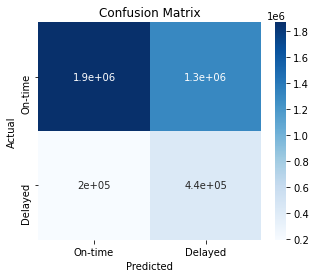

Class precision recall f1-score 
===========================================================
On-time 0.91 0.59 0.71 
Delayed 0.25 0.69 0.37 
-----------------------------------------------------------
Weighted 0.80 0.61 0.66 
===========================================================
Accuracy 0.61

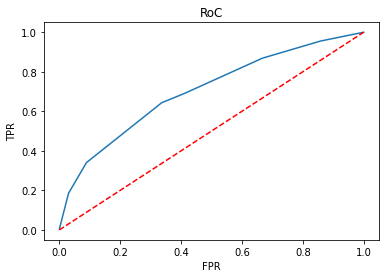

Area under ROC: 0.6397

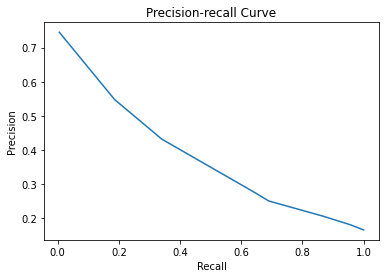

Area under precision-recall curve: 0.2378

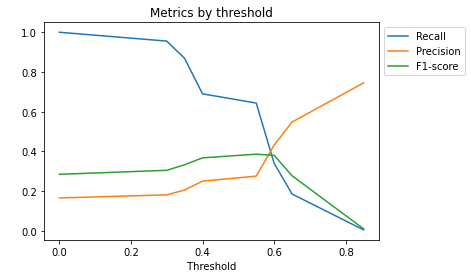

"{Param(parent='GBTClassifier_92555389d8f0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_92555389d8f0', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 10, Param(parent='GBTClassifier_92555389d8f0', name='maxIter', doc='max number of iterations (>= 0).'): 5}\n\nDone with CV (2 folds). Took 2.7279823144276936 mins\n Accuracy: 0.5923954905459043\n Precision: 0.23838641304872454\n Recall: 0.7026846588212132\n F1-score: 0.3558928559806569\n\n => Chosen as the best param!"

In [0]:
"""{Param(parent='GBTClassifier_92555389d8f0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_92555389d8f0', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 10, Param(parent='GBTClassifier_92555389d8f0', name='maxIter', doc='max number of iterations (>= 0).'): 5}

Done with CV (2 folds). Took 2.7279823144276936 mins
  Accuracy: 0.5923954905459043
  Precision: 0.23838641304872454
  Recall: 0.7026846588212132
  F1-score: 0.3558928559806569

  => Chosen as the best param!"""

gbt_classifier_best_w = GBTClassifier(featuresCol = 'features', labelCol = 'bc_DEP_DEL15_imputed', weightCol = "weight", maxDepth=2, maxIter=5, maxBins=10)

xgb_w = gbt_classifier_best_w.fit(df_train_w)

xgb_train_res = xgb_w.transform(df_train_w).repartition(40).cache()
ce = CustomEvaluator(xgb_train_res, col_y="bc_DEP_DEL15_imputed", col_yhat="prediction", col_prob="probability", nStep = 0.05)
ce.print_all()

In [0]:
print("Parameters of the best mode ", gsm.best_param_)
print()
print("Score of the best mode ", gsm.best_score_)
print()
print(gsm.cv_results_)

Out[40]: Parameters of the best mode {Param(parent='GBTClassifier_92555389d8f0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_92555389d8f0', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 20, Param(parent='GBTClassifier_92555389d8f0', name='maxIter', doc='max number of iterations (>= 0).'): 5}

Score of the best mode 0.7179415147501433

[{'param': {Param(parent='GBTClassifier_92555389d8f0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_92555389d8f0', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 10, Param(parent='GBTClassifier_92555389d8f0', name='maxIter', doc='max number of iterations (>= 0).'): 5}, 'score': 0.7026846588212132}, {'param': {Param(parent='GBTClassifier_92555389d8f0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_92555389d8f0', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 10, Param(parent='GBTClassifier_92555389d8f0', name='maxIter', doc='max number of iterations (>= 0).'): 10}, 'score': 0.6913889149621697}, {'param': {Param(parent='GBTClassifier_92555389d8f0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_92555389d8f0', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 20, Param(parent='GBTClassifier_92555389d8f0', name='maxIter', doc='max number of iterations (>= 0).'): 5}, 'score': 0.7179415147501433}, {'param': {Param(parent='GBTClassifier_92555389d8f0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_92555389d8f0', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 20, Param(parent='GBTClassifier_92555389d8f0', name='maxIter', doc='max number of iterations (>= 0).'): 10}, 'score': 0.7053637512170285}, {'param': {Param(parent='GBTClassifier_92555389d8f0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='GBTClassifier_92555389d8f0', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 10, Param(parent='GBTClassifier_92555389d8f0', name='maxIter', doc='max number of iterations (>= 0).'): 5}, 'score': 0.5710219250121539}, {'param': {Param(parent='GBTClassifier_92555389d8f0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='GBTClassifier_92555389d8f0', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 10, Param(parent='GBTClassifier_92555389d8f0', name='maxIter', doc='max number of iterations (>= 0).'): 10}, 'score': 0.5869336477339483}, {'param': {Param(parent='GBTClassifier_92555389d8f0', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='GBTClassifier_92555389d8f0', name='maxBins', doc='Max number of b

### Trial 2: GridSearch and Crossvalidation with undersampling (ratio 1) ，scoring=recall

In [0]:
gbt_classifier = GBTClassifier(featuresCol = 'features', labelCol = 'bc_DEP_DEL15_imputed')

cv = CustomCrossValidator(estimator = gbt_classifier, split_word = ("features", "bc_DEP_DEL15_imputed"), step_length=100, window_length=300, fh=[10, 300], verbose=True)

param_grid = ParamGridBuilder()\
            .addGrid(gbt_classifier.maxDepth, [2, 5])\
            .addGrid(gbt_classifier.maxBins, [10, 20])\
            .addGrid(gbt_classifier.maxIter, [5, 10])\
            .build()

gsm_under = CustomGridSearch(estimator = gbt_classifier, param_grid = param_grid, cv = cv, scoring = "recall", verbose = True )
gsm_under.fit(df_under)

Curernt param: {Param(parent='GBTClassifier_2f0b992851d3', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_2f0b992851d3', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 10, Param(parent='GBTClassifier_2f0b992851d3', name='maxIter', doc='max number of iterations (>= 0).'): 5}
Min timestamp of your data: : 1420106400
Max timestamp of your data: : 1546293480
Min date of your data: 2015-01-01 00:00:00
Max date of your data: 2019-01-01 00:00:00

 -Fold #1
 Trainset(234387): 2015-01-01 00:00:00 to 2015-10-27 23:59:59
 [Row(min(date)=1420106400.0, max(date)=1445990340.0)]
 Testset(252341): 2015-11-07 00:00:00 to 2016-09-01 23:59:59
 [Row(min(date)=1446854400.0, max(date)=1472774340.0)]
 Run the model...
 Accuracy: 0.6329490649557543
 Precision: 0.6100226584242544
 Recall: 0.7718526020567155
 F1-score: 0.6814617638562173

 -Fold #2
 Trainset(234669): 2015-04-11 00:00:00 to 2016-02-04 23:59:59
 [Row(min(date)=1428710400.0, max(date)=1454630340.0)]
 Testset(251828): 2016-02-15 00:00:00 to 2016-12-10 23:59:59
 [Row(min(date)=1455494400.0, max(date)=1481414160.0)]
 Run the model...
 Accuracy: 0.6388884476706324
 Precision: 0.6294181127854492
 Recall: 0.6454437506563164
 F1-score: 0.6373302066633167

 -Fold #3
 Trainset(228041): 2015-07-20 00:00:00 to 2016-05-14 23:59:59
 [Row(min(date)=1437350400.0, max(date)=1463270100.0)]
 Testset(258256): 2016-05-25 00:00:00 to 2017-03-20 23:59:59
 [Row(min(date)=1464134400.0, max(date)=1490054100.0)]
 Run the model...
 Accuracy: 0.6385989096090701
 Precision: 0.7072506180937485
 Recall: 0.5214308565646646
 F1-score: 0.6002895025352886

 -Fold #4
 Trainset(251247): 2015-10-28 00:00:00 to 2016-08-22 23:59:59
 [Row(min(date)=1445990400.0, max(date)=1471910160.0)]
 Testset(251671): 2016-09-02 00:00:00 to 2017-06-28 23:59:59
 [Row(min(date)=1472774400.0, max(date)=1498694340.0)]
 Run the model...
 Accuracy: 0.6377453103456496
 Precision: 0.6182770913010448
 Recall: 0.746230407523511
 F1-score: 0.6762544965146463

 -Fold #5
 Trainset(251219): 2016-02-05 00:00:00 to 2016-11-30 23:59:59
 [Row(min(date)=1454630400.0, max(date)=1480550160.0)]
 Testset(268396): 2016-12-11 00:00:00 to 2017-10-06 23:59:59
 [Row(min(date)=1481414760.0, max(date)=1507334340.0)]
 Run the model...
 Accuracy: 0.6418910863053101
 Precision: 0.6511873173680852
 Recall: 0.6868870812312228
 F1-score: 0.6685609652646789

 -Fold #6
 Trainset(257771): 2016-05-15 00:00:00 to 2017-03-10 23:59:59
 [Row(min(date)=1463270400.0, max(date)=1489190340.0)]
 Testset(261819): 2017-03-21 00:00:00 to 2018-01-14 23:59:59
 [Row(min(date)=1490054400.0, max(date)=1515974280.0)]
 Run the model...
 Accuracy: 0.6328608695320049
 Precision: 0.6042868263142733
 Recall: 0.7574931042695904
 F1-score: 0.6722717726318087

 -Fold #7
 Trainset(248821): 2016-08-23 00:00:00 to 2017-06-18 23:59:59
 [Row(min(date)=1471910400.0, max(date)=1497830340.0)]
 Testset(258445): 2017-06-29 00:00:00 to 2018-04-24 23:59:59
 [Row(min(date)=1498694400.0, max(date)=1524614340.0)]
 Run the model...
 Accuracy: 0.6342780862465902
 Precision: 0.5998192053856217
 Recall: 0.6707181775597248
 F1-score: 0.633290526830366

 -Fold #8
 Trainset(268261): 2016-12-01 00:00:00 to 2017-09-26 23:59:59
 [Row(min(date)=1480550400.0, max(date)=1506470100.0)]
 Testset(278729): 2017-10-07 00:00:00 to 2018-08-02 23:59:59
 [Row(min(date)=1507334700.0, max(date)=1533254340.0)]
 Run the model...
 Accuracy: 0.6415945237129972
 Precision: 0.6230725733042782
 Recall: 0.6663593722343502
 F1-score: 0.6439893943065673

 -Fold #9
 Trainset(261268): 2017-03-11 00:00:00 to 2018-01-04 23:59:59
 [Row(min(date)=1489190400.0, max(date)=1515110340.0)]
 Testset(299627): 2018-01-15 00:00:00 to 2018-11-10 23:59:59
 [Row(min(date)=1515974400.0, max(date)=1541894100.0)]
 Run the model...
 Accuracy: 0.63715886752

Out[60]:

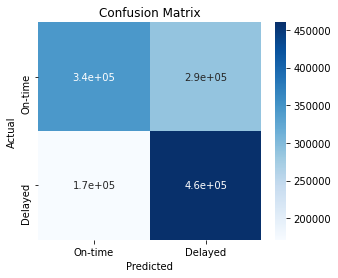

Class precision recall f1-score 
===========================================================
On-time 0.67 0.54 0.60 
Delayed 0.62 0.73 0.67 
-----------------------------------------------------------
Weighted 0.64 0.64 0.63 
===========================================================
Accuracy 0.64

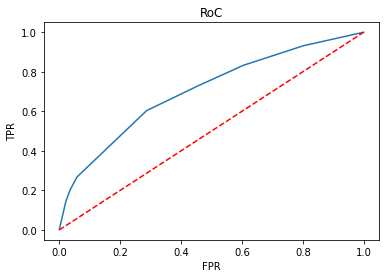

Area under ROC: 0.6366

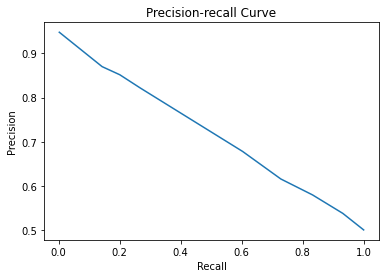

Area under precision-recall curve: 0.5998

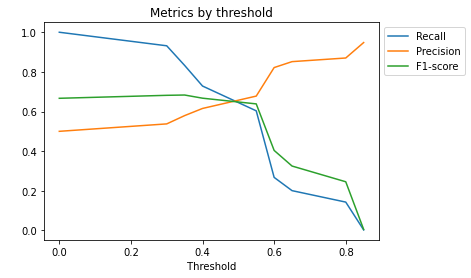

"Curernt param: {Param(parent='GBTClassifier_2f0b992851d3', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_2f0b992851d3', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 20, Param(parent='GBTClassifier_2f0b992851d3', name='maxIter', doc='max number of iterations (>= 0).'): 5}\nDone with CV (9 folds). Took 7.04978837966919 mins\n Accuracy: 0.6394391184034762\n Precision: 0.6284537222212332\n Recall: 0.6908950625535513\n F1-score: 0.6565470420827915\n\n => Chosen as the best param!\n\n"

In [0]:
'''Curernt param: {Param(parent='GBTClassifier_2f0b992851d3', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_2f0b992851d3', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20, Param(parent='GBTClassifier_2f0b992851d3', name='maxIter', doc='max number of iterations (>= 0).'): 5}
Done with CV (9 folds). Took 7.04978837966919 mins
  Accuracy: 0.6394391184034762
  Precision: 0.6284537222212332
  Recall: 0.6908950625535513
  F1-score: 0.6565470420827915

  => Chosen as the best param!

'''

gbt_classifier_under_1 = GBTClassifier(featuresCol = 'features', labelCol = 'bc_DEP_DEL15_imputed', maxDepth=2, maxIter=5, maxBins=20)

gbt_under_1 = gbt_classifier_under_1.fit(df_under)

gbt_train_under_res_1 = gbt_under_1.transform(df_under).repartition(40).cache()
ce_1 = CustomEvaluator(gbt_train_under_res_1, col_y="bc_DEP_DEL15_imputed", col_yhat="prediction", col_prob="probability", nStep = 0.05)
ce_1.print_all()

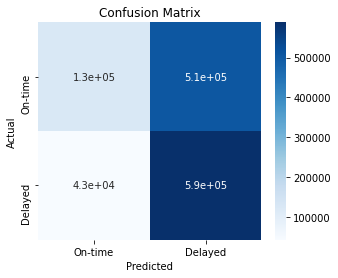

Class precision recall f1-score 
===========================================================
On-time 0.74 0.20 0.31 
Delayed 0.54 0.93 0.68 
-----------------------------------------------------------
Weighted 0.64 0.57 0.50 
===========================================================
Accuracy 0.57

In [0]:
## trainset
ce_1.set_threshold(0.3)
ce_1.show_metrics()

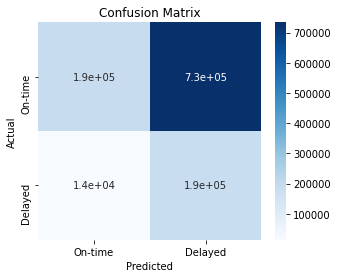

Class precision recall f1-score 
===========================================================
On-time 0.93 0.20 0.33 
Delayed 0.20 0.93 0.33 
-----------------------------------------------------------
Weighted 0.80 0.33 0.33 
===========================================================
Accuracy 0.33

In [0]:
gbt_test_under_res_1 = gbt_under_1.transform(df_test).repartition(40).cache()
ce_test_1 = CustomEvaluator(gbt_test_under_res_1, col_y="bc_DEP_DEL15_imputed", col_yhat="prediction", col_prob="probability", nStep = 0.05, threshold=0.3)
ce_test_1.show_metrics()

### Trial 3: GridSearch and CV with undersampling, scoring = F1

In [0]:
gbt_classifier = GBTClassifier(featuresCol = 'features', labelCol = 'bc_DEP_DEL15_imputed')

cv = CustomCrossValidator(estimator = gbt_classifier, split_word = ("features", "bc_DEP_DEL15_imputed"), step_length=100, window_length=300, fh=[10, 300], verbose=True)

param_grid = ParamGridBuilder()\
            .addGrid(gbt_classifier.maxDepth, [2, 5])\
            .addGrid(gbt_classifier.maxBins, [10, 20])\
            .addGrid(gbt_classifier.maxIter, [5, 10])\
            .build()

gsm_under_f1 = CustomGridSearch(estimator = gbt_classifier, param_grid = param_grid, cv = cv, scoring = "f1score", verbose = True )
gsm_under_f1.fit(df_under)

Curernt param: {Param(parent='GBTClassifier_c3e1d5d218da', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_c3e1d5d218da', name='maxBins', doc='Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature.'): 10, Param(parent='GBTClassifier_c3e1d5d218da', name='maxIter', doc='max number of iterations (>= 0).'): 5}
Min timestamp of your data: : 1420113600
Max timestamp of your data: : 1546293420
Min date of your data: 2015-01-01 00:00:00
Max date of your data: 2019-01-01 00:00:00

 -Fold #1
 Trainset(234144): 2015-01-01 00:00:00 to 2015-10-27 23:59:59
 [Row(min(date)=1420113600.0, max(date)=1445990340.0)]
 Testset(252439): 2015-11-07 00:00:00 to 2016-09-01 23:59:59
 [Row(min(date)=1446854400.0, max(date)=1472774340.0)]
 Run the model...
 Accuracy: 0.6361180324751722
 Precision: 0.6145268574297189
 Recall: 0.7629401682767217
 F1-score: 0.6807382177116641

 -Fold #2
 Trainset(234097): 2015-04-11 00:00:00 to 2016-02-04 23:59:59
 [Row(min(date)=1428710400.0, max(date)=1454630340.0)]
 Testset(251714): 2016-02-15 00:00:00 to 2016-12-10 23:59:59
 [Row(min(date)=1455494400.0, max(date)=1481414280.0)]
 Run the model...
 Accuracy: 0.6382004973898949
 Precision: 0.6190046762616088
 Recall: 0.6875368546895321
 F1-score: 0.6514734022196708

 -Fold #3
 Trainset(227957): 2015-07-20 00:00:00 to 2016-05-14 23:59:59
 [Row(min(date)=1437350460.0, max(date)=1463270160.0)]
 Testset(257905): 2016-05-25 00:00:00 to 2017-03-20 23:59:59
 [Row(min(date)=1464134400.0, max(date)=1490054100.0)]
 Run the model...
 Accuracy: 0.6425234097826719
 Precision: 0.6714455130287867
 Recall: 0.6150108995677372
 F1-score: 0.6419903619510642

 -Fold #4
 Trainset(251426): 2015-10-28 00:00:00 to 2016-08-22 23:59:59
 [Row(min(date)=1445990400.0, max(date)=1471910340.0)]
 Testset(251255): 2016-09-02 00:00:00 to 2017-06-28 23:59:59
 [Row(min(date)=1472774400.0, max(date)=1498694340.0)]
 Run the model...
 Accuracy: 0.6361903245706553
 Precision: 0.6164978851341346
 Recall: 0.7504702194357367
 F1-score: 0.6769189443287891

 -Fold #5
 Trainset(251412): 2016-02-05 00:00:00 to 2016-11-30 23:59:59
 [Row(min(date)=1454630400.0, max(date)=1480550220.0)]
 Testset(268653): 2016-12-11 00:00:00 to 2017-10-06 23:59:59
 [Row(min(date)=1481414400.0, max(date)=1507334100.0)]
 Run the model...
 Accuracy: 0.6394829017356962
 Precision: 0.6461130252267236
 Recall: 0.6936256448047163
 F1-score: 0.669026838986584

 -Fold #6
 Trainset(257334): 2016-05-15 00:00:00 to 2017-03-10 23:59:59
 [Row(min(date)=1463270400.0, max(date)=1489190340.0)]
 Testset(262194): 2017-03-21 00:00:00 to 2018-01-14 23:59:59
 [Row(min(date)=1490054400.0, max(date)=1515974340.0)]
 Run the model...
 Accuracy: 0.6337254094296589
 Precision: 0.6052271213205359
 Recall: 0.753858919886595
 F1-score: 0.6714157163435054

 -Fold #7
 Trainset(248643): 2016-08-23 00:00:00 to 2017-06-18 23:59:59
 [Row(min(date)=1471910400.0, max(date)=1497830340.0)]
 Testset(258489): 2017-06-29 00:00:00 to 2018-04-24 23:59:59
 [Row(min(date)=1498694400.0, max(date)=1524614280.0)]
 Run the model...
 Accuracy: 0.6342745726123742
 Precision: 0.5997442737153061
 Recall: 0.6707181775597248
 F1-score: 0.6332487605037128

 -Fold #8
 Trainset(268358): 2016-12-01 00:00:00 to 2017-09-26 23:59:59
 [Row(min(date)=1480550400.0, max(date)=1506470100.0)]
 Testset(278694): 2017-10-07 00:00:00 to 2018-08-02 23:59:59
 [Row(min(date)=1507334400.0, max(date)=1533254340.0)]
 Run the model...
 Accuracy: 0.6425721400532484
 Precision: 0.6242995432780338
 Recall: 0.6663593722343502
 F1-score: 0.6446441375718378

 -Fold #9
 Trainset(261731): 2017-03-11 00:00:00 to 2018-01-04 23:59:59
 [Row(min(date)=1489190400.0, max(date)=1515110340.0)]
 Testset(299698): 2018-01-15 00:00:00 to 2018-11-10 23:59:59
 [Row(min(date)=1515974400.0, max(date)=1541894220.0)]
 Run the model...
 Accuracy: 0.63053473830

Out[66]: Out[66]:

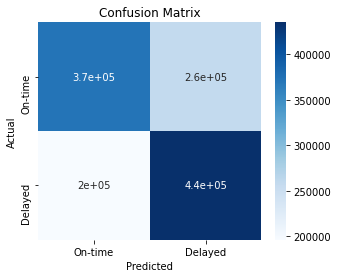

Class precision recall f1-score 
===========================================================
On-time 0.65 0.59 0.62 
Delayed 0.63 0.69 0.66 
-----------------------------------------------------------
Weighted 0.64 0.64 0.64 
===========================================================
Accuracy 0.64

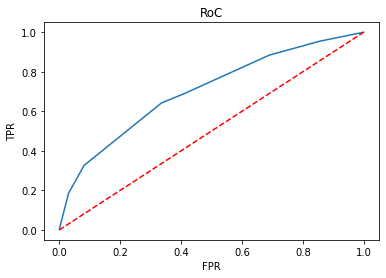

Area under ROC: 0.6396

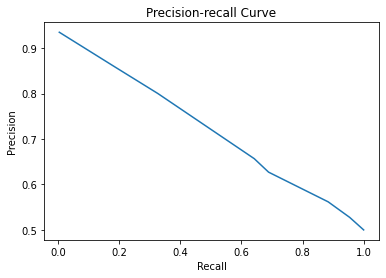

Area under precision-recall curve: 0.6074

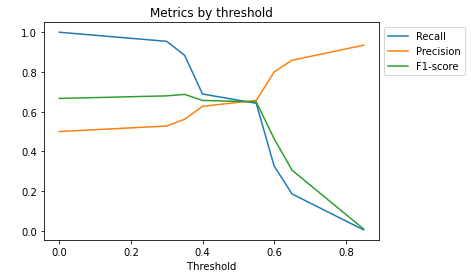

'\n => Chosen as the best param!'

In [0]:
'''Curernt param: {Param(parent='GBTClassifier_c3e1d5d218da', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_c3e1d5d218da', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 10, Param(parent='GBTClassifier_c3e1d5d218da', name='maxIter', doc='max number of iterations (>= 0).'): 5}



Done with CV (9 folds). Took 1.8272880514462788 mins
  Accuracy: 0.6370691140391775
  Precision: 0.6220839448227357
  Recall: 0.707276697362606
  F1-score: 0.6603513325877807'''
'''
  => Chosen as the best param!'''

gbt_classifier_under_1 = GBTClassifier(featuresCol = 'features', labelCol = 'bc_DEP_DEL15_imputed', maxDepth=2, maxIter=5, maxBins=10)

gbt_under_best1 = gbt_classifier_under_1.fit(df_under)

gbt_train_under_res_f1 = gbt_under_best1.transform(df_under).repartition(40).cache()
ce_f1 = CustomEvaluator(gbt_train_under_res_f1, col_y="bc_DEP_DEL15_imputed", col_yhat="prediction", col_prob="probability", nStep = 0.05)
ce_f1.print_all()

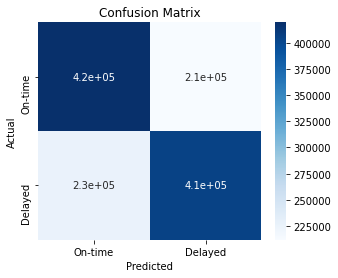

Class precision recall f1-score 
===========================================================
On-time 0.65 0.66 0.66 
Delayed 0.66 0.64 0.65 
-----------------------------------------------------------
Weighted 0.65 0.65 0.65 
===========================================================
Accuracy 0.65

In [0]:
ce_f1.set_threshold(0.55)
ce_f1.show_metrics()

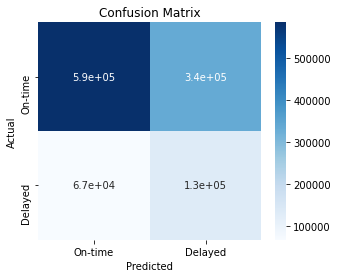

Class precision recall f1-score 
===========================================================
On-time 0.90 0.64 0.74 
Delayed 0.28 0.66 0.40 
-----------------------------------------------------------
Weighted 0.79 0.64 0.68 
===========================================================
Accuracy 0.64

In [0]:
gbt_test_under_res_f1 = gbt_under_best1.transform(df_test).repartition(40).cache()
ce_test_f1 = CustomEvaluator(gbt_test_under_res_f1, col_y="bc_DEP_DEL15_imputed", col_yhat="prediction", col_prob="probability", nStep = 0.05, threshold=0.55)
ce_test_f1.show_metrics()

# Model Evaluation and Summary

As discussed in question formulation section of the main notebook, our main stakeholder is C-level business people, so reliablity and trust lost by being delayed is even riskier than cancel the flight ticket. Recall of delay class is selected to be our evaluation metric for model selection. Our training set is imbalanced between delay and on-time class. To address the imbalance, we tried two approches, using weight for classification or undersampling the majority class delay in the training set. Our result on Trial 1 with weights achieved high recall (0.9) but low precision (0.2) and low F1 score(0.35). The tradeoff between high recall and lower value of other metrics is very clear. 

Alternatively, we tried unsampling the major class delay and resampled our training set in Trial 2. This time, with probability of 0.5 to classify labels, we were able to achieve recall of 0.73, where precision of 0.62 and F1 score of 0.67, all being more than 0.5 cutoff point from the training step. To further address the imblanace issue, we used Throshold Moving technique to find the best balance between the true positive rate and the false positive rate. Looking at the graph Metrics by Threshold, once we dialed threshold to 0.3, the recall reached 0.93 where precision and F1 score still over 0.5. Evaluating our test model using 0.3 as threshold, the recall scored 0.93. The test set was evaluated and gave high recall 0.93 on delay class, with sacrifices in precision. This is chosen as the best model. 

Clearly, achieving high recall without losing precision and F1 score seems inevitable in the Trial 1 and 2. Therefore, F1 score is chosen as scoring metric in the Trial 3 to see whether this could avoid lowering precision and recall. For the training set, all three metrics are balanced at ~0.65 without tradeoff. However, the model performance on test set showed moderate level of recall (0.66) and F1 score (0.40) but low precision (0.28).

In conclusion, the gridsearch with cross validation model with undersampled training set generated the best recall in both training and test set. Even though other metrics are lower, but for our stakeholders, the cost of misclassifying a delay is worse than the cost of misclassifying a non-delayed. Having the best recall is aligned with our business case.

__Evaluation results of test set__:

| Model              | undersampling | class weight | precision |&nbsp;&nbsp; recall &nbsp;&nbsp;   | f1-score | Params    | cutoff
| ------------------ | --------------| ------------ | --------- | --------------------------------- | -------- |--------   | --------
| Grid Search Trial 2       | Yes          | No           | 0.2       | 0.93                      | 0.33      |maxDepth = 2, maxBins = 20, minIter = 5| 0.3